In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import random
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Conv1D, Bidirectional, GRU, Flatten, Activation, BatchNormalization,Input
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
from keras.models import load_model
from keras_self_attention import SeqSelfAttention
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply,Lambda
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import backend as K 
print(tf.__version__)
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_random_seed(seed=42)
np.random.RandomState(42)
random.seed(42)
K.clear_session()
import pandas as pd
from pandas import DataFrame
from sklearn import preprocessing
from pylab import rcParams


1.15.0


Using TensorFlow backend.


In [2]:
r=pd.read_excel("Raspberries.xlsx")
r=r.iloc[293:3244,-1:].values
pys=pd.read_excel("Ifeanyi soil yield price 5W.xlsx")
s=pys.iloc[:,2:3].values
x=pys.iloc[:,21:]

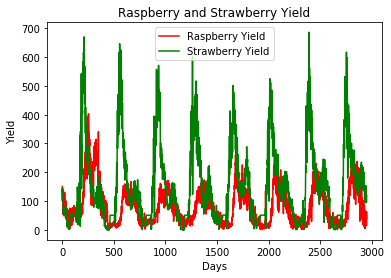

In [3]:
plt.plot(r,color='r',label="Raspberry Yield")
plt.plot(s,color='g',label="Strawberry Yield")
plt.ylabel("Yield")
plt.xlabel("Days")
plt.title("Raspberry and Strawberry Yield")
plt.legend()
plt.savefig('Strawberry and Raspberry Yield', quality=100, dpi=256, optimize=True)

In [4]:
#set random seed for reproducibility
print(tf.__version__)
import os
import random
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_random_seed(seed=42)
np.random.RandomState(42)
random.seed(42)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
 
data=x.values
print(data.shape)
data = series_to_supervised(data, 139)
print(data)

scaler = preprocessing.StandardScaler().fit(data)
scaler

d= scaler.transform(data)

1.15.0
(2951, 1)
      var1(t-139)  var1(t-138)  var1(t-137)  var1(t-136)  var1(t-135)  \
139     23.029219    22.941509    23.314857    23.823008    24.544578   
140     22.941509    23.314857    23.823008    24.544578    24.732229   
141     23.314857    23.823008    24.544578    24.732229    24.296427   
142     23.823008    24.544578    24.732229    24.296427    23.559654   
143     24.544578    24.732229    24.296427    23.559654    22.640521   
...           ...          ...          ...          ...          ...   
2946    10.500922    10.900842    12.176407    12.823652    13.076309   
2947    10.900842    12.176407    12.823652    13.076309    12.858931   
2948    12.176407    12.823652    13.076309    12.858931    13.083156   
2949    12.823652    13.076309    12.858931    13.083156    13.297900   
2950    13.076309    12.858931    13.083156    13.297900    12.819717   

      var1(t-134)  var1(t-133)  var1(t-132)  var1(t-131)  var1(t-130)  ...  \
139     24.732229    24.2964

In [5]:
from sklearn.decomposition import PCA

my_model = PCA(n_components=20)
d=my_model.fit_transform(d)
X=d
    
x_train = X[0:int(0.8*X.shape[0])]
x_test = X[int(0.8*X.shape[0]):]
print(x_train.shape)
print(x_test.shape)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)

(2249, 20)
(563, 20)


In [6]:
keras.backend.clear_session()

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_random_seed(seed=42)
np.random.RandomState(42)
random.seed(42)

model_lime_cnn_lstm_att = keras.models.Sequential([
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=(20, 1)),
      #keras.layers.BatchNormalization(),
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu"),
      #keras.layers.BatchNormalization(),
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu"),
      #keras.layers.BatchNormalization(),
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu"),
      #keras.layers.BatchNormalization(),
      keras.layers.LSTM(100, return_sequences=True, activation='relu'),
      #keras.layers.Dropout(0.15),
      keras.layers.LSTM(100, return_sequences=True, activation='relu'),
      SeqSelfAttention(attention_activation='sigmoid'),
      #tf.keras.layers.Dropout(0.15),
      #tf.keras.layers.LSTM(100, return_sequences=True, activation='relu'),
      keras.layers.Flatten(),
      keras.layers.Dense(64, activation="relu"),
      #keras.layers.Dropout(0.15),
      keras.layers.Dense(32, activation="relu"),
      #keras.layers.Dropout(0.15),
      keras.layers.Dense(16, activation="relu"),
      keras.layers.Dense(1),
      keras.layers.Lambda(lambda x: x * 400)
])




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Transfer Learning using weights trained on strawberry

## Transferring the learning on Raspberry 



R2 Score:  -3.73082959051208  , MAE:  90.46938167891678  , RMSE:  145.54759677462485  , Agg:  558.2780527656334
R2 Score:  -4.7568409345382765  , MAE:  97.96191425619354  , RMSE:  152.3672676183166  , Agg:  720.5526406623286


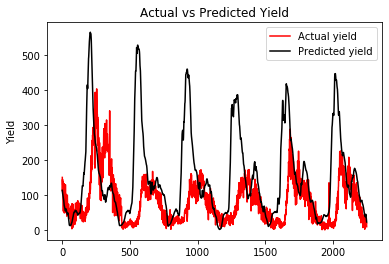

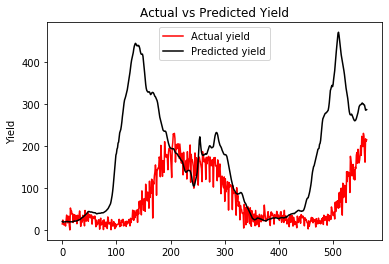

In [7]:
Y=r
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


#Loading weights trained on strawberry
filepath_lime_cnn_lstm_att1 = "weights_lime_cnn_lstm_att_Strawberry.best.hdf5"
model_lime_cnn_lstm_att.load_weights(filepath_lime_cnn_lstm_att1)

y_pred = model_lime_cnn_lstm_att.predict(x_train)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='r', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model_lime_cnn_lstm_att.predict(x_test)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='r', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)


## Transferring the learning on Raspberry after Freezing

In [8]:
Y=r
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


#Loading weights trained on strawberry
filepath_lime_cnn_lstm_att1 = "weights_lime_cnn_lstm_att_Strawberry.best.hdf5"
model_lime_cnn_lstm_att.load_weights(filepath_lime_cnn_lstm_att1)

model_lime_cnn_lstm_att.trainable = False

inputs = keras.Input(shape=(20, 1))

x = model_lime_cnn_lstm_att(inputs)
x=keras.layers.Dense(64, activation="relu")(x)
x=keras.layers.Dense(32, activation="relu")(x)
x=keras.layers.Dense(16, activation="relu")(x)

outputs = keras.layers.Dense(1)(x)

#outputs=keras.layers.Lambda(lambda x: x * 400)(x)

model = keras.Model(inputs, outputs)
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=["mae"])

history = model.fit(x_train, y_train,  validation_data= (x_test, y_test),epochs=100)



Train on 2249 samples, validate on 563 samples
Epoch 1/100
2249/2249 [==============================] - 1s 382us/step - loss: 6230.8705 - mae: 59.2937 - val_loss: 4359.4677 - val_mae: 52.0017
Epoch 2/100
2249/2249 [==============================] - 1s 254us/step - loss: 6178.3552 - mae: 59.0994 - val_loss: 4392.2111 - val_mae: 52.0520
Epoch 3/100
2249/2249 [==============================] - 1s 256us/step - loss: 6175.7387 - mae: 58.7714 - val_loss: 4398.5852 - val_mae: 52.0460
Epoch 4/100
2249/2249 [==============================] - 1s 256us/step - loss: 6170.2347 - mae: 58.6693 - val_loss: 4354.7458 - val_mae: 51.9353
Epoch 5/100
2249/2249 [==============================] - 1s 257us/step - loss: 6171.8502 - mae: 59.0299 - val_loss: 4386.4077 - val_mae: 51.9830
Epoch 6/100
2249/2249 [==============================] - 1s 256us/step - loss: 6167.3548 - mae: 58.7555 - val_loss: 4370.5277 - val_mae: 51.9309
Epoch 7/100
2249/2249 [==============================] - 1s 258us/step - loss: 6159

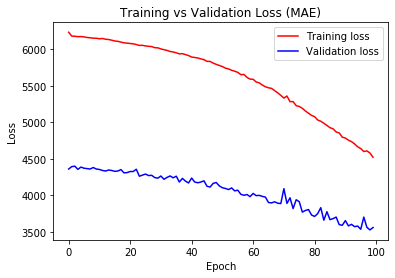

In [9]:
plt.figure()
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], color='r', label='Training loss')
plt.plot(np.arange(len(history.history['loss'])), history.history['val_loss'], color='b', label='Validation loss')
plt.title('Training vs Validation Loss (MAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('CNN-LSTM attention Lime 5P week(s) ahead - loss curve.jpg', quality=100, dpi=256, optimize=True)
    

R2 Score:  -0.0070421801271018936  , MAE:  48.957886769604364  , RMSE:  67.15219567411785  , Agg:  58.463875279431775
R2 Score:  0.117369888653997  , MAE:  48.950991129597405  , RMSE:  59.66078101122924  , Agg:  47.932010269072265


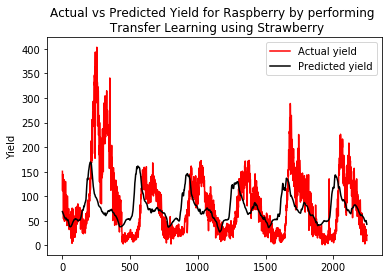

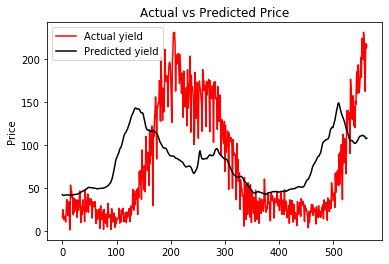

In [10]:
Y=r
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


y_pred = model.predict(x_train)
y_pred=y_pred
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='r', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield for Raspberry by performing \n Transfer Learning using Strawberry')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Transfer Learning on Raspberry using Strawberry.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model.predict(x_test)
y_pred=y_pred

y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='r', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Price')
plt.ylabel('Price')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)

## Transferring the learning on Raspberry after Fine Tuning

In [11]:
model_lime_cnn_lstm_att.trainable = True

fp="Weights_FT.h5"

checkpoint = keras.callbacks.ModelCheckpoint(fp,
                                 monitor = 'val_loss',
                                 verbose = 0,
                                 save_best_only = True,
                                 mode = 'min')

optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=["mae"])

history = model.fit(x_train, y_train,  validation_data= (x_test, y_test),epochs=100, callbacks = [checkpoint])

Train on 2249 samples, validate on 563 samples
Epoch 1/100
2249/2249 [==============================] - 3s 1ms/step - loss: 2305.3052 - mae: 32.7748 - val_loss: 886.9841 - val_mae: 22.1326
Epoch 2/100
2249/2249 [==============================] - 2s 792us/step - loss: 1455.8335 - mae: 25.9979 - val_loss: 911.7342 - val_mae: 21.7224
Epoch 3/100
2249/2249 [==============================] - 2s 801us/step - loss: 1323.4962 - mae: 24.8677 - val_loss: 918.0501 - val_mae: 21.9781
Epoch 4/100
2249/2249 [==============================] - 2s 788us/step - loss: 1166.9326 - mae: 23.1907 - val_loss: 1017.3538 - val_mae: 22.6640
Epoch 5/100
2249/2249 [==============================] - 2s 792us/step - loss: 1105.4561 - mae: 22.5088 - val_loss: 1297.7903 - val_mae: 24.4206
Epoch 6/100
2249/2249 [==============================] - 2s 800us/step - loss: 1034.3193 - mae: 21.8336 - val_loss: 1362.2517 - val_mae: 25.0469
Epoch 7/100
2249/2249 [==============================] - 2s 798us/step - loss: 996.2903 

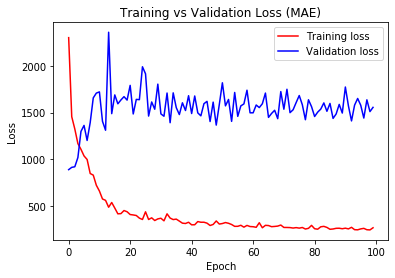

In [12]:
plt.figure()
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], color='r', label='Training loss')
plt.plot(np.arange(len(history.history['loss'])), history.history['val_loss'], color='b', label='Validation loss')
plt.title('Training vs Validation Loss (MAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig('CNN-LSTM attention Lime 5P week(s) ahead - loss curve.jpg', quality=100, dpi=256, optimize=True)
    

R2 Score:  0.6519246786516555  , MAE:  25.88467575769962  , RMSE:  39.47962356179743  , Agg:  11.375849745171656
R2 Score:  0.7800536762593482  , MAE:  22.13256242897105  , RMSE:  29.7822783503085  , Agg:  5.709239188491906


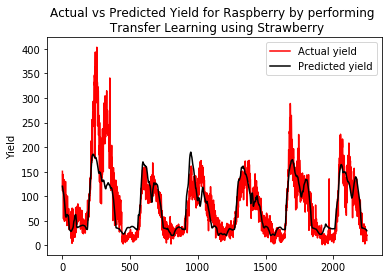

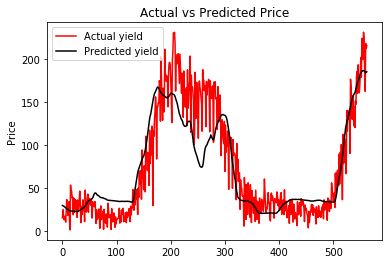

In [13]:
Y=r
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]

model.load_weights(fp)

y_pred = model.predict(x_train)
y_pred=y_pred
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='r', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield for Raspberry by performing \n Transfer Learning using Strawberry')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Transfer Learning on Raspberry using Strawberry.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model.predict(x_test)
y_pred=y_pred

y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='r', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Price')
plt.ylabel('Price')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)

R2 Score:  0.6519246786516555  , MAE:  25.88467575769962  , RMSE:  39.47962356179743  , Agg:  11.375849745171656
R2 Score:  0.7800536762593482  , MAE:  22.13256242897105  , RMSE:  29.7822783503085  , Agg:  5.709239188491906


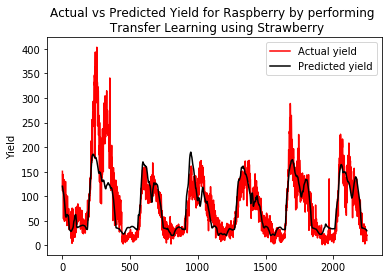

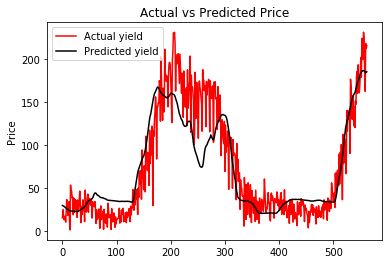

In [14]:
Y=r
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


y_pred = model.predict(x_train)
y_pred=y_pred
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='r', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield for Raspberry by performing \n Transfer Learning using Strawberry')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Transfer Learning on Raspberry using Strawberry.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model.predict(x_test)
y_pred=y_pred

y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='r', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Price')
plt.ylabel('Price')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)

In [15]:
np.savetxt("Raspberry_Yield.txt",y_pred_1x ,delimiter=",")

## On Strawberry itself

R2 Score:  0.9244159849634482  , MAE:  23.8669860105135  , RMSE:  35.76565690069973  , Agg:  2.2536372892352317
R2 Score:  0.846327084987514  , MAE:  39.842729874021416  , RMSE:  59.15953996166107  , Agg:  7.606983699251022


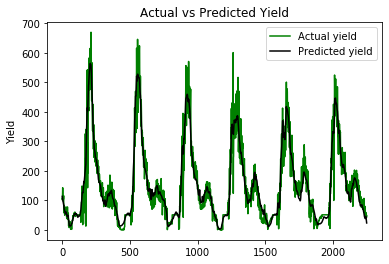

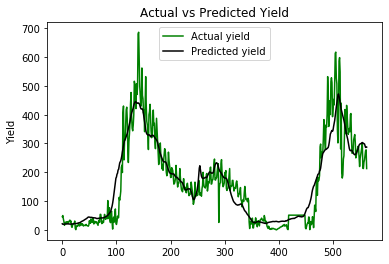

In [68]:
Y=s
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


y_pred = model_lime_cnn_lstm_att.predict(x_train)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='g', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model_lime_cnn_lstm_att.predict(x_test)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='g', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)

# Transfer Learning using weights trained on Raspberry


## Transfer Learning on Raspberry by without freezing layers

R2 Score:  -0.17242243133150792  , MAE:  81.60945137252591  , RMSE:  140.86181713369882  , Agg:  130.41515276173635
R2 Score:  -0.2465590382056635  , MAE:  99.91624713939206  , RMSE:  168.4932663295286  , Agg:  167.29415247753388


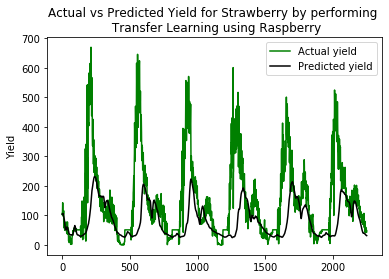

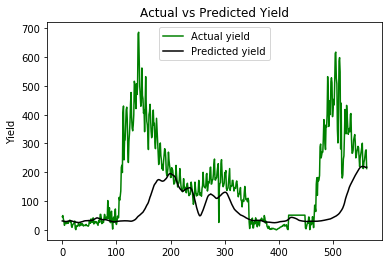

In [69]:
Y=s
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


#Loading weights trained on strawberry
filepath_lime_cnn_lstm_att1 = "weights_lime_cnn_lstm_att_Raspberry.best.hdf5"
model_lime_cnn_lstm_att.load_weights(filepath_lime_cnn_lstm_att1)

y_pred = model_lime_cnn_lstm_att.predict(x_train)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='g', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield for Strawberry by performing \n Transfer Learning using Raspberry')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Transfer Learning on Strawberry using Raspberry.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model_lime_cnn_lstm_att.predict(x_test)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='g', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)


## Transfer Learning on Raspberry by freezing layers

In [70]:
Y=s
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


#Loading weights trained on strawberry
filepath_lime_cnn_lstm_att1 = "weights_lime_cnn_lstm_att_Raspberry.best.hdf5"
model_lime_cnn_lstm_att.load_weights(filepath_lime_cnn_lstm_att1)

model_lime_cnn_lstm_att.trainable = False

inputs = keras.Input(shape=(20, 1))

x = model_lime_cnn_lstm_att(inputs)
x=keras.layers.Dense(64, activation="relu")(x)
x=keras.layers.Dense(32, activation="relu")(x)
x=keras.layers.Dense(16, activation="relu")(x)

outputs = keras.layers.Dense(1)(x)

#outputs=keras.layers.Lambda(lambda x: x * 400)(x)

model = keras.Model(inputs, outputs)
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=["mae"])

history = model.fit(x_train, y_train,  validation_data= (x_test, y_test),epochs=100)



Train on 2249 samples, validate on 563 samples
Epoch 1/100
2249/2249 [==============================] - 2s 695us/step - loss: 36342.6014 - mae: 141.4890 - val_loss: 44666.4321 - val_mae: 151.6394
Epoch 2/100
2249/2249 [==============================] - 1s 291us/step - loss: 32606.6387 - mae: 129.9101 - val_loss: 40860.0222 - val_mae: 141.2565
Epoch 3/100
2249/2249 [==============================] - 1s 291us/step - loss: 29214.7962 - mae: 118.3626 - val_loss: 37276.7924 - val_mae: 130.6311
Epoch 4/100
2249/2249 [==============================] - 1s 292us/step - loss: 25858.6988 - mae: 105.3233 - val_loss: 33608.6591 - val_mae: 118.7913
Epoch 5/100
2249/2249 [==============================] - 1s 292us/step - loss: 22724.9988 - mae: 92.4721 - val_loss: 30228.7234 - val_mae: 106.6970
Epoch 6/100
2249/2249 [==============================] - 1s 293us/step - loss: 20206.4506 - mae: 82.9069 - val_loss: 27529.7018 - val_mae: 97.1325
Epoch 7/100
2249/2249 [==============================] - 1s 29

R2 Score:  0.0019513411864697794  , MAE:  80.94101222611471  , RMSE:  129.96520158375392  , Agg:  105.24733191418952
R2 Score:  -0.02790358680079308  , MAE:  92.62449034556191  , RMSE:  153.00383421010036  , Agg:  126.24111791531729


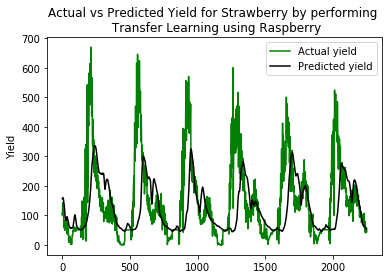

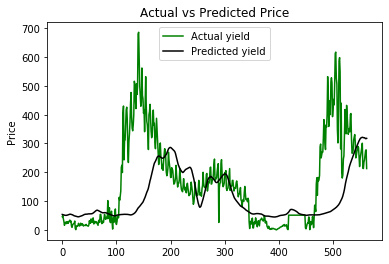

In [71]:
Y=s
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


y_pred = model.predict(x_train)
y_pred=y_pred
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='g', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield for Strawberry by performing \n Transfer Learning using Raspberry')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Transfer Learning on Strawberry using Raspberry Freezing.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model.predict(x_test)
y_pred=y_pred

y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='g', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Price')
plt.ylabel('Price')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)

## Transfer Learning on Raspberry by Fine tuning

In [72]:
model_lime_cnn_lstm_att.trainable = True

optimizer = keras.optimizers.Adam(lr=1e-5)
model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=["mae"])

history = model.fit(x_train, y_train,  validation_data= (x_test, y_test),epochs=100)

Train on 2249 samples, validate on 563 samples
Epoch 1/100
2249/2249 [==============================] - 3s 2ms/step - loss: 14009.7478 - mae: 81.4395 - val_loss: 15114.3949 - val_mae: 81.1666
Epoch 2/100
2249/2249 [==============================] - 2s 831us/step - loss: 10517.5375 - mae: 72.5334 - val_loss: 11725.3989 - val_mae: 75.5285
Epoch 3/100
2249/2249 [==============================] - 2s 826us/step - loss: 9114.3983 - mae: 67.4469 - val_loss: 10355.7637 - val_mae: 73.3789
Epoch 4/100
2249/2249 [==============================] - 2s 846us/step - loss: 8364.0239 - mae: 65.1645 - val_loss: 9839.0411 - val_mae: 69.6705
Epoch 5/100
2249/2249 [==============================] - 2s 842us/step - loss: 7859.7301 - mae: 62.3054 - val_loss: 9081.3793 - val_mae: 69.6238
Epoch 6/100
2249/2249 [==============================] - 2s 850us/step - loss: 7474.4926 - mae: 61.7310 - val_loss: 8673.9056 - val_mae: 66.4982
Epoch 7/100
2249/2249 [==============================] - 2s 836us/step - loss: 7

R2 Score:  0.9057265896839567  , MAE:  27.076685749965012  , RMSE:  39.943474179681886  , Agg:  3.159109518247223
R2 Score:  0.79560829153773  , MAE:  47.36365070372661  , RMSE:  68.22723328494976  , Agg:  11.812909130554806


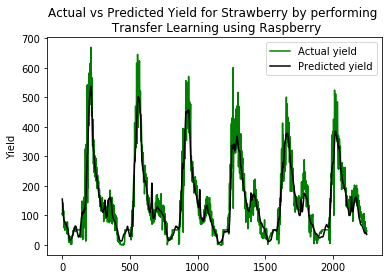

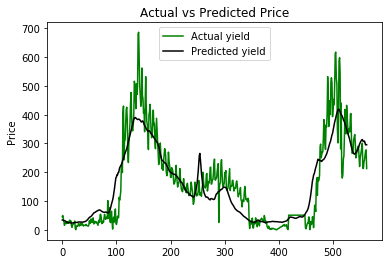

In [73]:
Y=s
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


y_pred = model.predict(x_train)
y_pred=y_pred
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='g', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield for Strawberry by performing \n Transfer Learning using Raspberry')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Transfer Learning on Strawberry using Raspberry FT.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model.predict(x_test)
y_pred=y_pred

y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='g', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Price')
plt.ylabel('Price')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)

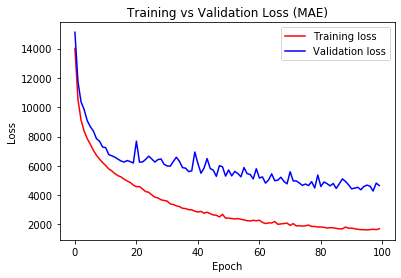

In [74]:
plt.figure()
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], color='r', label='Training loss')
plt.plot(np.arange(len(history.history['loss'])), history.history['val_loss'], color='b', label='Validation loss')
plt.title('Training vs Validation Loss (MAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('CNN-LSTM attention Lime 5P week(s) ahead - loss curve.jpg', quality=100, dpi=256, optimize=True)
    

## On Raspberry itself

R2 Score:  0.6977152391232802  , MAE:  25.104441096105678  , RMSE:  36.791247457768826  , Agg:  9.35506170690394
R2 Score:  0.8007206999343186  , MAE:  19.44984204643415  , RMSE:  28.348537538701514  , Agg:  4.762613813999795


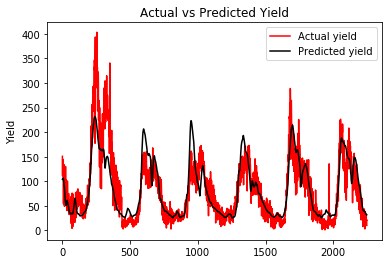

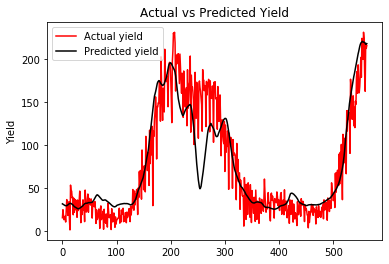

In [45]:
Y=r
Y=Y[:2812]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]


y_pred = model_lime_cnn_lstm_att.predict(x_train)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_train)), y_train, color='r', label='Actual yield')
plt.plot(np.arange(len(y_train)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)





y_pred = model_lime_cnn_lstm_att.predict(x_test)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='r', label='Actual yield')
plt.plot(np.arange(len(y_test)), y_pred, color='k', label='Predicted yield')
plt.title('Actual vs Predicted Yield')
plt.ylabel('Yield')
plt.legend()
plt.savefig('Lime AC-LSTM 5P week(s) ahead plot.jpg', quality=100, dpi=256, optimize=True)


r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)